In [1]:
# Import Required Modules

import os
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Rescaling, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_PATH = '/kaggle/input/charanetmelspec/CharaNetMelSpec'
# BIRDS = os.listdir(f'{DATA_PATH}/train')
BIRDS = ['Spotted Dove',
 'Swamp Francolin',
 'Rufous-necked Hornbill',
 'Jerdon_s Babbler',
 'Rose-ringed Parakeet',
 'Wood Snipe',
 'Large-billed Crow',
 'Greater Spotted Eagle',
 'Saker Falcon',
 'Rufous Treepie',
 'Indian Spotted Eagle',
 'Satyr Tragopan',
 'Steppe Eagle',
 'House Crow',
 'Long-tailed Duck',
 'Asian Koel',
 'Red-billed Blue Magpie',
 'Pallas_s Fish Eagle',
 'Cheer Pheasant',
 'Rustic Bunting',
 'Grey Treepie',
 'Sarus Crane',
 'Spiny Babbler',
 'Kashmir Flycatcher',
 'Swamp Grass-babbler',
 'Great Slaty Woodpecker',
 'Eastern Imperial Eagle',
 'Black Kite',
 'Black-necked crane',
 'Common Wood Pigeon',
 'Bristled Grassbird',
 'Grey-sided Thrush',
 'House Sparrow',
 'Grey-crowned Prinia',
 'White-throated Bushchat',
 'Himalayan Monal',
 'Black-breasted Parrotbill',
 'Egyptian Vulture',
 'Common Pochard',
 'Common Cuckoo',
 'Slender-billed Babbler']
BATCH_SIZE = 2
IM_SIZE = (128, 128) 
NO_CLASSES = len(BIRDS)

In [3]:
# Load the train, validation and testing dataset

from tensorflow.keras.applications.efficientnet import preprocess_input

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)
train_batches = train_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "train"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  rescale=1./255)
valid_batches = valid_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "val"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255)
test_batches = test_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "test"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 5414 images belonging to 41 classes.
Found 639 images belonging to 41 classes.
Found 687 images belonging to 41 classes.


In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3

lr = 0.0001
loss = "categorical_crossentropy"

# Transfer learning EfficientNetB3
model = EfficientNetB3(
    include_top=False, weights="imagenet", input_tensor=None, input_shape=(IM_SIZE[0],IM_SIZE[1], 3)
)
x = model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(BIRDS), activation="softmax", name="softmax")(x)
model = Model(inputs=model.input, outputs=output_layer)
model.compile(
    optimizer=Adam(learning_rate=lr), loss=loss, metrics=["accuracy"]
)

# print(model.summary())

43950080/43941136 [==============================] - 0s 0us/step


In [5]:
# print(model.summary())

In [6]:
# Define callbacks

# Model checkpoint
logs_directory = 'model/logs/'
checkpoint = ModelCheckpoint(
    r"model/model_checkpoint",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
    period=1,
)

# ReduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=3e-4)
# Function for exponential learning rate decay after 5 epochs
def scheduler(epoch, lr):
  decay = -0.1
  if epoch < 5:
    return lr
  else:
    return lr * math.exp((epoch+1)*decay)

lrscheduler = LearningRateScheduler(scheduler)

# Early stopping if val_loss does not decrease for 3 epochs
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

callbacks = [checkpoint, lrscheduler, early_stopping_monitor]

In [7]:
# Train the model

EPOCHS = 30
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=EPOCHS,
    callbacks= callbacks)

Epoch 1/30
2707/2707 [==============================] - 221s 75ms/step - loss: 2.7351 - accuracy: 0.2789 - val_loss: 3.4583 - val_accuracy: 0.1189
Epoch 2/30
2707/2707 [==============================] - 203s 75ms/step - loss: 1.8942 - accuracy: 0.4765 - val_loss: 3.7062 - val_accuracy: 0.0908
Epoch 3/30
2707/2707 [==============================] - 200s 74ms/step - loss: 1.5328 - accuracy: 0.5567 - val_loss: 5.7233 - val_accuracy: 0.0063
Epoch 4/30
2707/2707 [==============================] - 201s 74ms/step - loss: 1.2817 - accuracy: 0.6286 - val_loss: 1.8221 - val_accuracy: 0.5290
Epoch 5/30
2707/2707 [==============================] - 201s 74ms/step - loss: 1.1659 - accuracy: 0.6683 - val_loss: 1.9042 - val_accuracy: 0.4773
Epoch 6/30
2707/2707 [==============================] - 204s 75ms/step - loss: 0.8193 - accuracy: 0.7503 - val_loss: 3.0327 - val_accuracy: 0.2801
Epoch 7/30
2707/2707 [==============================] - 205s 76ms/step - loss: 0.6538 - accuracy: 0.8014 - val_loss: 1

In [8]:
model.save('./model/CNMelSpec_Model_v2')
model_loaded = load_model('./model/CNMelSpec_Model_v2')
model_loaded.evaluate(test_batches)

344/344 [==============================] - 12s 26ms/step - loss: 0.7764 - accuracy: 0.7904


[0.7763894200325012, 0.7903929948806763]

In [9]:
model.evaluate(test_batches)

344/344 [==============================] - 8s 24ms/step - loss: 0.7764 - accuracy: 0.7904


[0.7763894200325012, 0.7903929948806763]

In [24]:
import shutil

dir_name = '/kaggle/working/model/CNMelSpec_Model_v2'
output_filename = dir_name.split('/')[-1]

shutil.make_archive(output_filename, 'zip', dir_name)

'/kaggle/working/CNMelSpec_Model.zip'

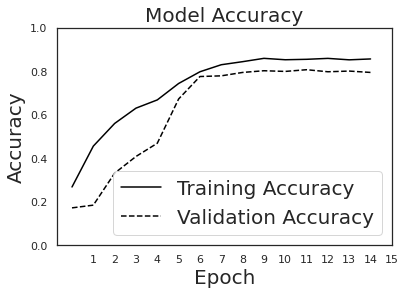

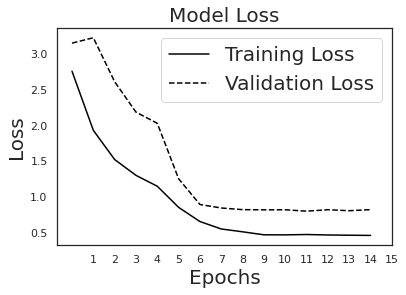

In [20]:
# Accuracy and Loss 

from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()
sns.set_style(style='white')

# Accuracy vs epochs plot
def accuracy_plot(model, history, epochs):

    annot_size = 20
    fig_size = (10, 10)

    plt.plot(history.history['accuracy'], label='Training Accuracy', color='black')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', linestyle='dashed', color='black')
    
    plt.title('Model Accuracy', fontsize=annot_size)
    plt.xlabel('Epoch', fontsize=annot_size)
    plt.ylabel('Accuracy', fontsize=annot_size)
    plt.ylim([0, 1])
    plt.xticks(list(range(1, epochs+1)))
    plt.legend(loc='lower right', fontsize=annot_size)
    plt.savefig('accuracy.jpg', bbox_inches='tight')
    plt.show()

# Loss vs epochs plot
def loss_plot(model, history, epochs):
    annot_size = 20
    fig_size = (10, 10)

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, label='Training Loss', color='black')
    plt.plot(val_loss, label = 'Validation Loss', linestyle='dashed', color='black')
    
    plt.title('Model Loss', fontsize=annot_size)
    plt.xlabel('Epochs', fontsize=annot_size)
    plt.ylabel('Loss', fontsize=annot_size)
#     plt.ylim([0, 0.85])
    plt.xticks(list(range(1, epochs+1)))
    plt.legend(loc='upper right', fontsize=annot_size)
    plt.savefig('loss.jpg', bbox_inches='tight')
    plt.show()

accuracy_plot(model, history, epochs=15)
loss_plot(model, history, epochs=15)

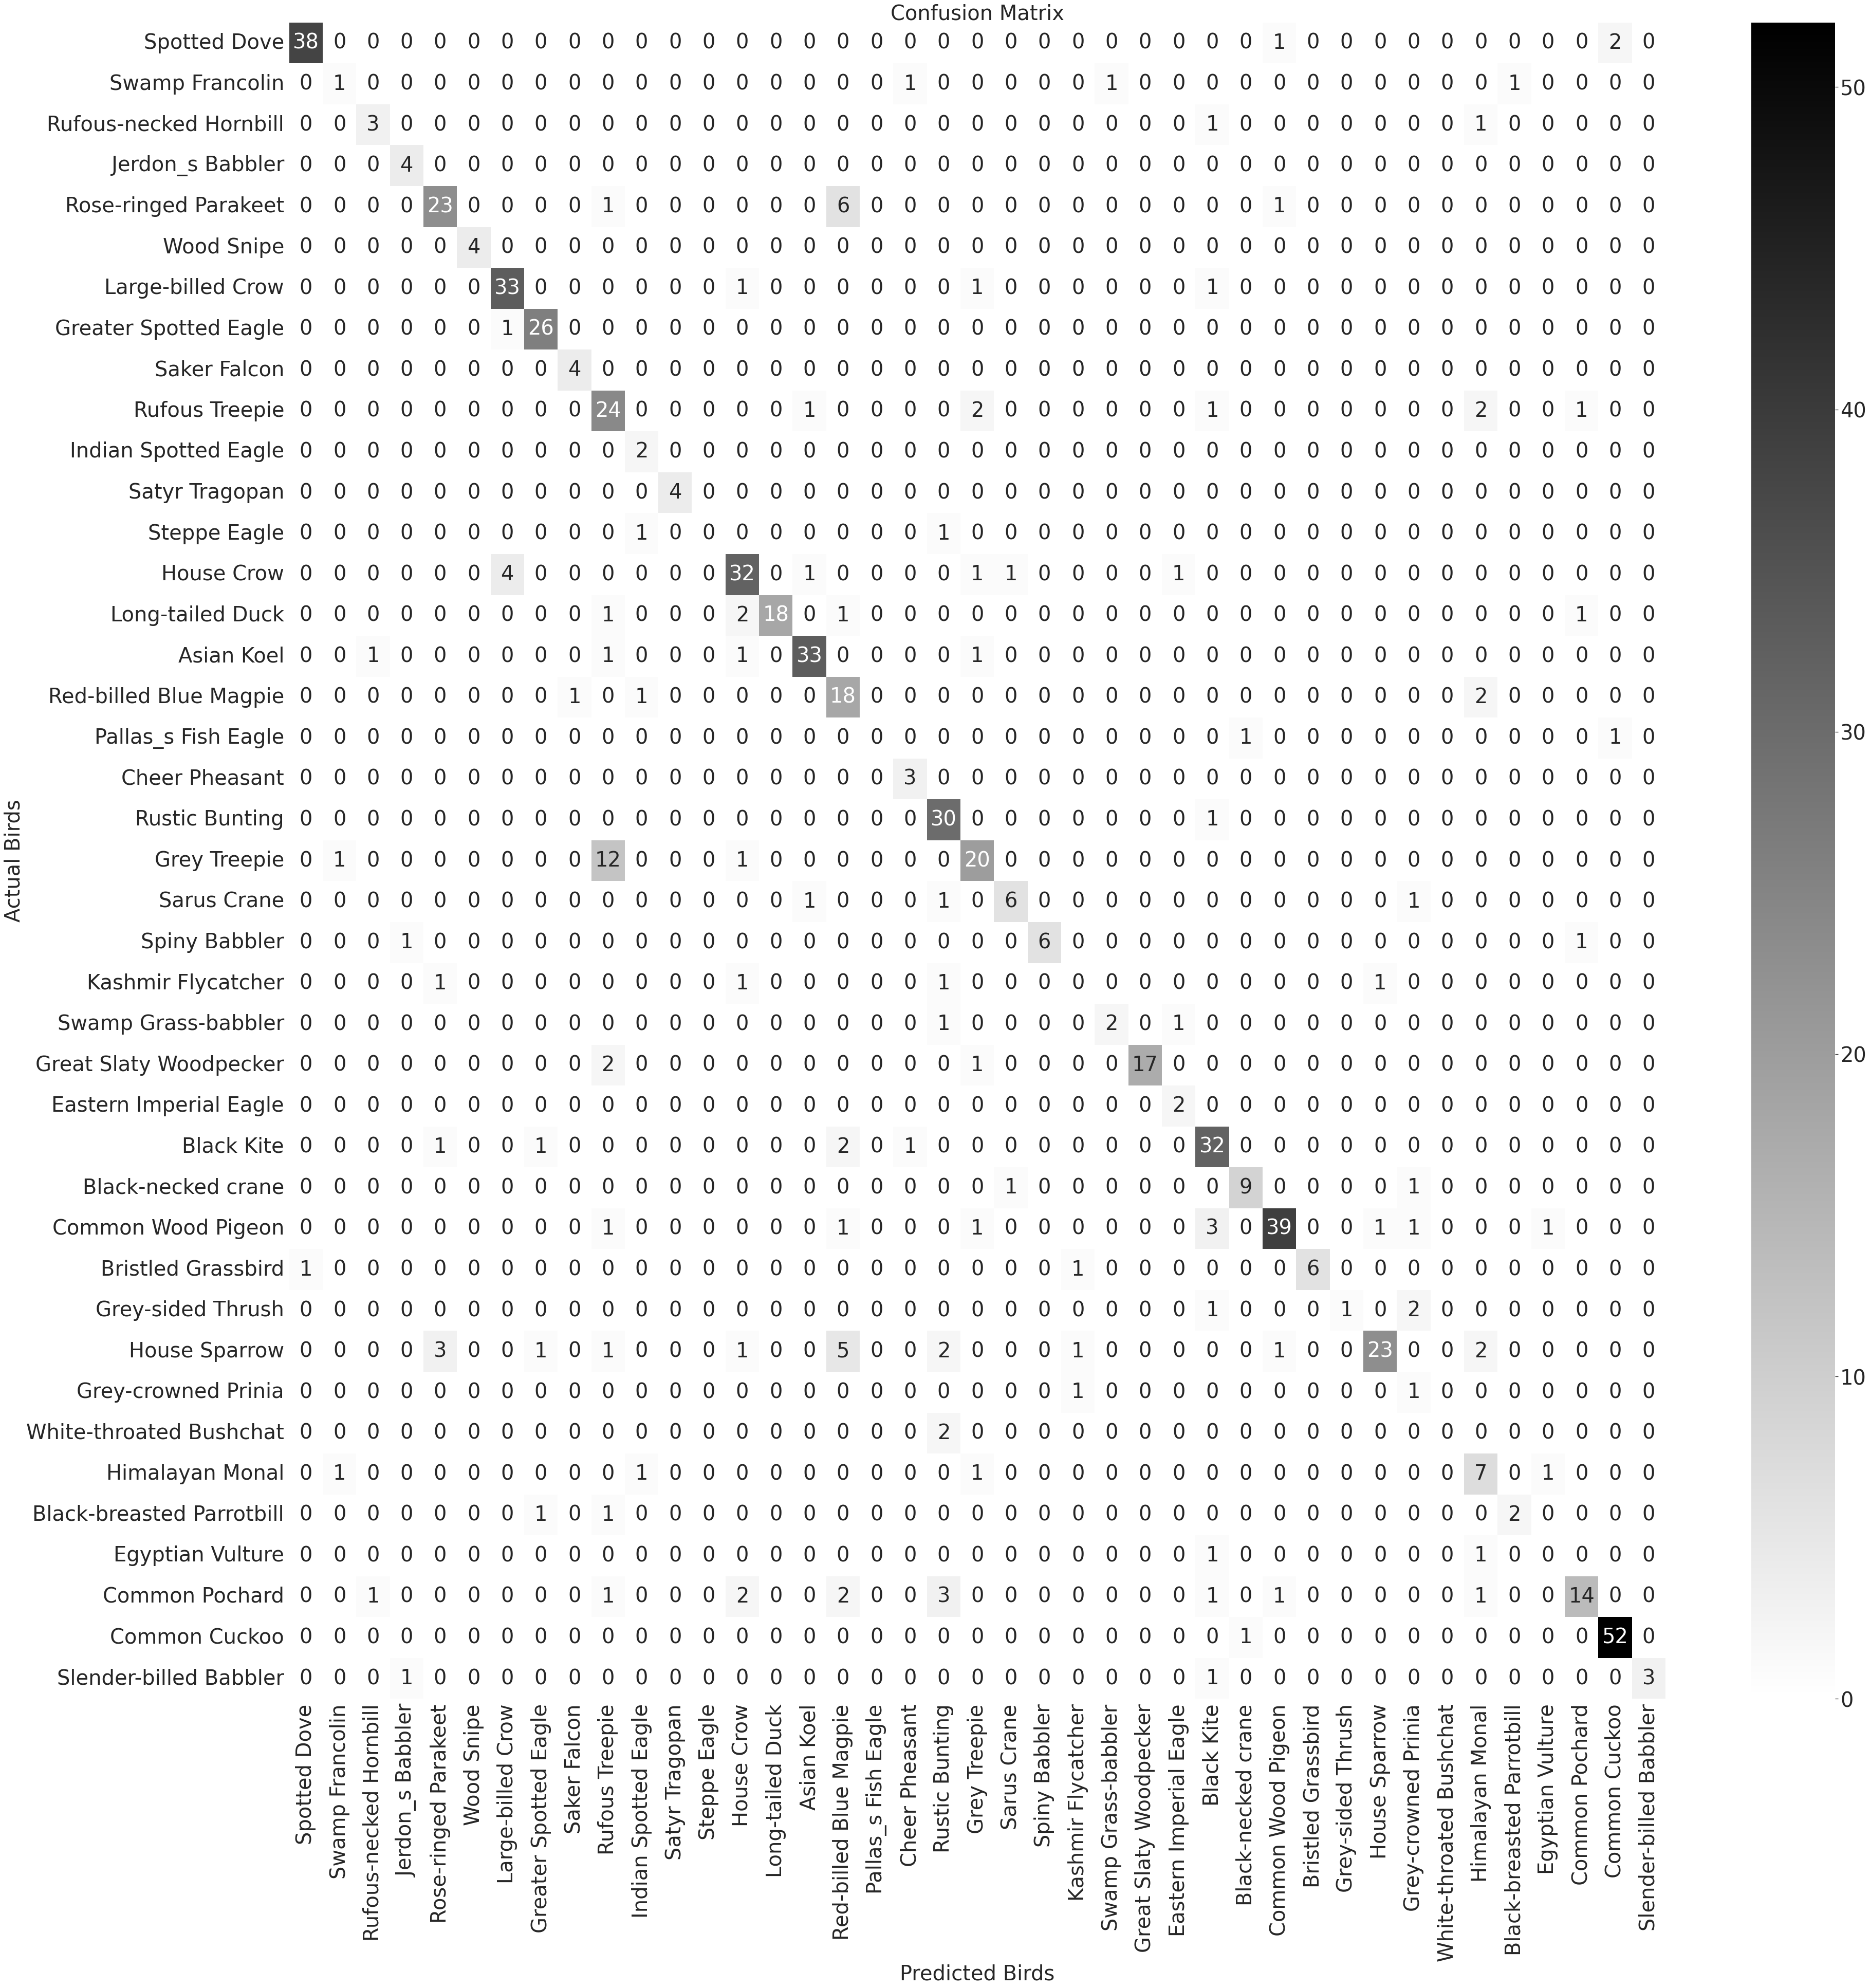

In [21]:
# Confusion Matrix

def confusion_matrix_plot(model, test_batches):
    
    annot_size = 40
    fig_size = (60, 60)

    preds = model_loaded.predict(x=test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes

    confuse = confusion_matrix(y_true, y_preds)

    plt.rcParams["font.family"] = "Times New Roman"
    sns.set(rc = {'figure.figsize':fig_size, 'xtick.labelsize':annot_size, 'ytick.labelsize':annot_size})
    # plt.rcParams['figure.figsize'] = fig_size
    conf_df = pd.DataFrame(confuse)
    conf_df.index = BIRDS
    conf_df.columns = BIRDS
    sns.heatmap(conf_df, annot=True, cmap='binary', annot_kws={'size': annot_size})
    plt.title('Confusion Matrix', fontdict={'fontsize':annot_size}) 
    plt.xlabel('Predicted Birds', fontdict={'fontsize':annot_size})
    plt.ylabel('Actual Birds', fontdict={'fontsize':annot_size})
    plt.savefig('Confusion Matrix.png', dpi=200, format='png', bbox_inches='tight')

confusion_matrix_plot(model, test_batches)

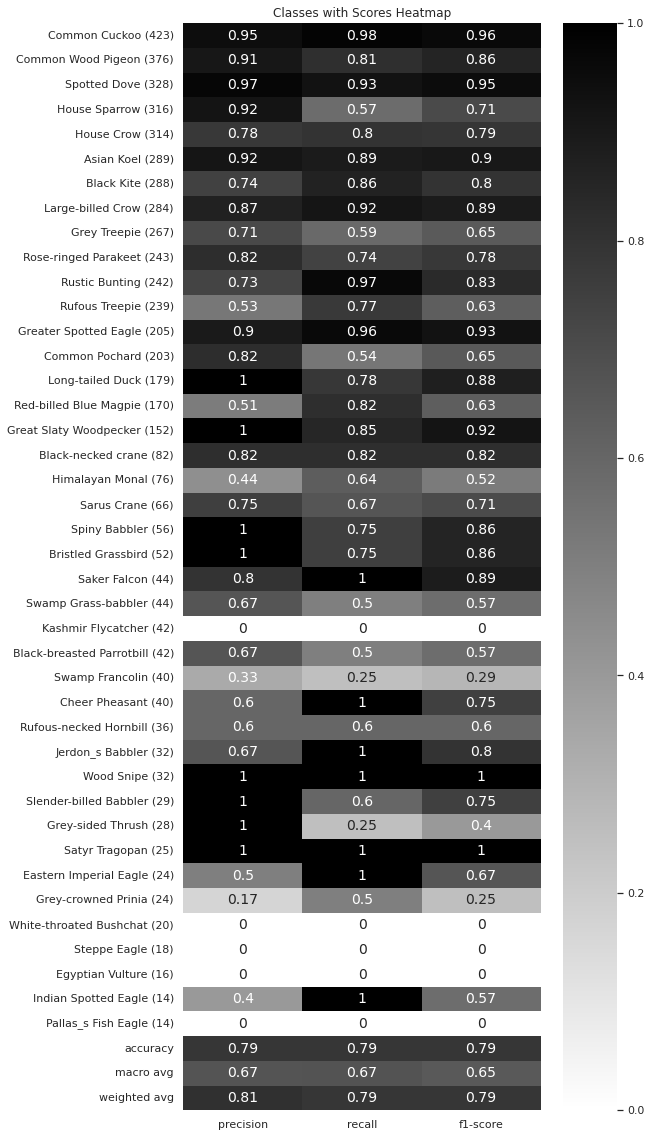

In [22]:
# Classes with scores heatmap

def class_scores(classes_dir, model, test_batches):
    
    birds_train_count = {}
    annot_size = 14
    fig_size = (8,20)
    
    for f in os.listdir(classes_dir):
        birds_train_count[f] = len(os.listdir(os.path.join(train_dir, f)))

    birds_train_count = dict(sorted(birds_train_count.items(), key= lambda x: x[1], reverse=True))

    preds = model.predict(x=test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes
    clf_report = classification_report(y_true, y_preds, output_dict=True)
    cls_df = pd.DataFrame(clf_report).iloc[:-1, :].T
    acc_to_counts = [str(BIRDS.index(bird)) for bird in [k for k in birds_train_count.keys()]] + ['accuracy', 'macro avg', 'weighted avg']

    cls_df = cls_df.reindex(acc_to_counts)
    y_label = [f"{k} ({v})" for k, v in birds_train_count.items()] + ['accuracy', 'macro avg', 'weighted avg']
    cls_df.index = y_label

    sns.set(rc = {'figure.figsize':fig_size})
    sns.heatmap(cls_df, annot=True, annot_kws={'size': annot_size}, cmap='binary')
    plt.title('Classes with Scores Heatmap') 
    plt.savefig('Classes with Scores Heatmap.png', dpi=200, format='png', bbox_inches='tight')

train_dir = '/kaggle/input/charanetmelspec/CharaNetMelSpec/train'

class_scores(train_dir, model_loaded, test_batches)

In [31]:
# # Inference

# # !pip install pydub
# import os
# import numpy as np
# import librosa
# import librosa.display
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications.efficientnet import preprocess_input
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.layers import Rescaling

# from pydub import AudioSegment
# import math
# import shutil

# import warnings
# warnings.filterwarnings("ignore")

# # # Turn interactive plotting off
# # import matplotlib
# # matplotlib.use('Agg')
# # plt.ioff()

# # Variables for feature extraction
# SAMPLE_RATE = 32000
# SPEC_SHAPE = (48, 128) # height x width
# SIGNAL_LENGTH = 10
# N_FFT = 1024         
# HOP_SIZE =  int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))      
# N_MELS = SPEC_SHAPE[0]   
# WIN_SIZE = 1024      
# WINDOW_TYPE = 'hann' 
# FEATURE = 'mel'      
# FMIN = 500
# FMAX = 12500

# def SplitAudio(audio_file, sec_to_split=10):
    
#     validAudio = lambda audio, amp_threshold: True if audio.max > amp_threshold else False
    
#     global temp_n
#     temp_n = 0
#     mili=1000
#     export_folder = f'./inference/tmp'
#     export_name = audio_file.split('/')[-1]
#     exportFormat = 'mp3'
#     try:
#         audio = AudioSegment.from_mp3(audio_file)
#     except:
#         print("File handled: ", audio_file)
#         extension = audio_file.split('.')[-1]
#         if extension == 'wav':
#             audio = AudioSegment.from_wav(audio_file)
#         elif extension == 'ogg':
#             audio = AudioSegment.from_ogg(audio_file)
#     th = audio.max//2
 
#     duration = math.floor(audio.duration_seconds)
#     splits = np.arange(0, duration, sec_to_split)

#     if duration > sec_to_split:
#         rem = duration % sec_to_split
#         n_splits = round(duration / sec_to_split)
#         for n in range(n_splits-1): # Except last splitted file
#             newAudio = audio[splits[n]*mili:splits[n+1]*mili]
#             temp_n = n
#             if validAudio(newAudio, th):
#                 newAudio.export(f'{export_folder}/{export_name}{n}.{exportFormat}', format=exportFormat)
        
#         # For the last splitted file
#         if rem <= sec_to_split//2:
#             n = temp_n
#             # If remaining  audio is small enough, don't separate
#             newAudio = audio[splits[n+1]*mili:duration*mili]
#             if validAudio(newAudio, th):
#                 newAudio.export(f'{export_folder}/{export_name}{n+1}.{exportFormat}', format=exportFormat)

#         else:
#             n = temp_n
#             # If remaining audio is big enough, make it separate file
#             newAudio = audio[splits[n+1]*mili:duration*mili]
#             if validAudio(newAudio, th):
#                 newAudio.export(f'{export_folder}/{export_name}{n+1}.{exportFormat}', format=exportFormat)

#     else:
#         if validAudio(audio, th):
#             audio.export(f'{export_folder}/{export_name}original.{exportFormat}', format=exportFormat)

# def create_features(inference_data_path):
    
#     # Find the list of all 10 sec splitted audio files
#     audio_files = [f for f in os.listdir(inference_data_path) if f.split('.')[-1]=='mp3']
#     count = 0
#     for aud in audio_files:

#         signal, sr = librosa.load(os.path.join(inference_data_path, aud),duration=10) # sr = sampling rate
#         # Plot mel-spectrogram
#         S = librosa.feature.melspectrogram(y=signal,
#                                            sr=SAMPLE_RATE,
#                                             n_fft=N_FFT,
#                                             hop_length=HOP_SIZE, 
#                                             n_mels=N_MELS, 
#                                             fmin=FMIN, 
#                                             fmax=FMAX) 

#         fig = plt.figure(figsize=(10, 4))
#         mel_spec = librosa.power_to_db(S, ref=np.max) 
#         librosa.display.specshow(mel_spec, fmin=FMIN,y_axis='linear')
        
#         plt.axis(False)
#         plt.tight_layout()
#         # plt.show()
#         count += 1
#         plt.savefig(f'{inference_data_path}/inf{count}.jpg')
#         plt.close(fig)
        
# def preprocess_img(image_dir, img_size):
#     img_width, img_height = img_size[0], img_size[1]
#     img = image.load_img(image_dir, target_size = (img_width, img_height))
#     img = image.img_to_array(img)
#     img = np.expand_dims(img, axis = 0)
#     norm = Rescaling(1./255)
#     img = norm(img)
#     img = preprocess_input(img) 
#     return img

# def prediction(model_dir, inference_data_path, img_size):
#     # List of feature images
#     feat = [os.path.join(inference_data_path, f) for f in os.listdir(inference_data_path) if f.split('.')[-1]=='jpg']
#     results = []
#     for m in feat:
#         model_loaded = load_model(model_dir)
#         img = preprocess_img(m, img_size)
#         output = BIRDS[np.argmax(model_loaded.predict(img), axis=-1)[0]]
#         results.append(output)
#     result = max(results)
    
#     # Remove the temporary splitted audio and mfcc images
#     for i in os.listdir(inference_data_path):
#         os.remove(os.path.join(inference_data_path, i))
#     return results

In [36]:
# inference_data_path = './inference/tmp'
# raw_data_path = '/kaggle/input/chara-net-demo/CharaNetDemo/test/Spiny Babbler/XC361954 0.mp3'
# model_dir = '/kaggle/working/model/CNMelSpec_Model'
# img_size = (128, 128)

# if 'inference' not in os.listdir('./'):
#     os.makedirs(inference_data_path)

# SplitAudio(raw_data_path)
# create_features(inference_data_path)
# result = prediction(model_dir, inference_data_path, img_size)
# print(max(result))

Black Kite


['Long-tailed Duck']